# Time Series Analysis Mini Project

In [1]:
import pandas as pd
import numpy as np
import datetime
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Acquire!

### Imported steps from my personal Iphone pedometer. 

#### Steps to repeat:
1. Export from Iphone pedometer in settings
2. Save to file
3. Upload using pandas!

In [2]:
df = pd.read_csv("Export.csv")

In [3]:
df.head(2)

,Date,Steps,Distance,Floors Ascended
0,8/16/20,14656,6.7,0
1,8/15/20,10103,4.7,8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             589 non-null    object 
 1   Steps            589 non-null    int64  
 2   Distance         589 non-null    float64
 3   Floors Ascended  589 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 18.5+ KB


# Prepare!!

### Initial thoughts:
- This is a really simple data frame
- Only 3 columns to explore in additon to datetime

### Action Items:
- Lets rename some columns in a pythonic manner (h/t Ryan Orsinger)
- Lets set the index as datetime so we can do some time series analysis.

### Personal Notes on Time-Series Analysis
- For the past couple of projects I have been blowing off TSA by moving the target variable from the next time-series row into the current row.  For this mini-project I wanted to do "pure" TSA.
- I also have been anxious to explore FB prophet, so I will be importing and exploring here.


In [5]:
#rename columns
df = df.rename(columns={'Date':'date',
                  'Steps': 'steps',
                    'Distance': 'distance',
                  'Floors Ascended': 'floors_ascended'})

In [6]:
# # set index to datetime
df['date'] = pd.to_datetime(df.date)
df = df.sort_values('date').set_index('date')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 589 entries, 2018-08-26 to 2020-08-16
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   steps            589 non-null    int64  
 1   distance         589 non-null    float64
 2   floors_ascended  589 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 18.4 KB


# Explore!!!

### Questions to explore:
1. What is the relationship between `steps` and `distance`?
2. Is there any value to the `floors_ascended` column?
3. What day of the week do I walk the most?
4. Do I purposefully try to get over my steps ceiling (10,000 steps)?
5. How often do I cross my steps ceiling?

In [8]:
df['validate_steps'] = df.steps/ df.distance

In [9]:
df.validate_steps.describe()

count     588.000000
mean     2288.413467
std       142.308722
min      1864.565217
25%      2187.159515
50%      2292.075758
75%      2389.688735
max      2704.000000
Name: validate_steps, dtype: float64

Text(0.5, 1.0, 'Histogram of steps per mile by day')

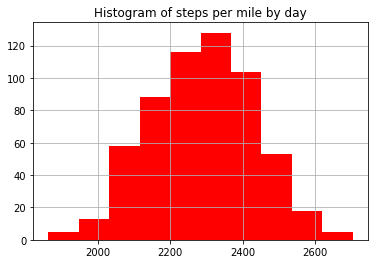

In [10]:
df.validate_steps.hist(color='red')
plt.title("Histogram of steps per mile by day")

**Takeaways**: It looks like there is enough of a variation the steps and distance are not calculated off the same data, which means that both columns have value in exploration. 

    (Unnecessary explanation: if steps and distance had little to no variation then we could assume that they are being calculated by the same measure either gps location or a gyroscopic movement within the phone.  Since they are not, we can examine the relationship between the two features, or use either as a target. 
    
**Next step**:  Prove it statistically

             steps  distance
steps     1.000000  0.992054
distance  0.992054  1.000000


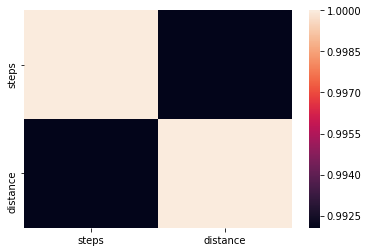

In [11]:
print(df[['steps', 'distance']].corr())
sns.heatmap(df[['steps', 'distance']].corr())

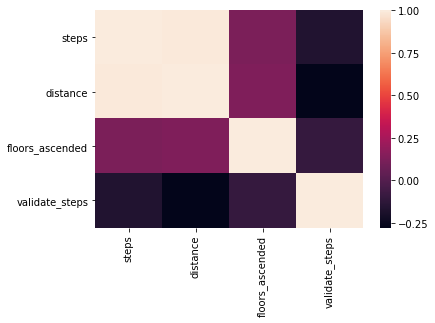

In [12]:
sns.heatmap(df.corr())

In [13]:
# exploring floors_ascended:
df.floors_ascended.describe()

count    589.000000
mean       1.298812
std        2.159227
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       22.000000
Name: floors_ascended, dtype: float64

### Is there a use for floors ascended?

Text(0.5, 1.0, 'How many floors do I walk up?')

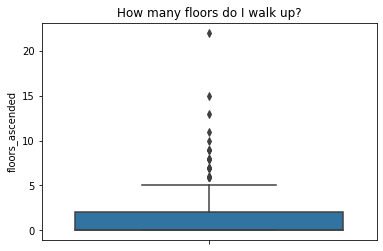

In [14]:
sns.boxplot(y='floors_ascended', data=df)
plt.title('How many floors do I walk up?')

**Takeaways**:  Anecdotal information:  My house is single story.  I don't walk up stairs to go to work.  My neighboorhood is flat.  More than 50% of the days, I do not walk up a flight of stairs.   However, there might be some valuable information in what days are the non-zero days.  Worth taking a look...

In [15]:
print(f'I do not ascend a full set of stairs {round((df.floors_ascended == 0).mean(),4 )*100} percent of the days in this data set')

I do not ascend a full set of stairs 53.31 percent of the days in this data set


Text(0, 0.5, 'Frequency')

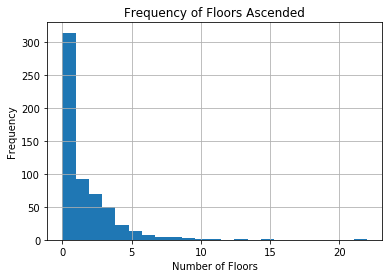

In [16]:
df.floors_ascended.hist(bins=23)
plt.title("Frequency of Floors Ascended")
plt.xlabel('Number of Floors')
plt.ylabel('Frequency')

### Is there a relationship between distance I walked and weather I climbed a floor?

In [17]:
# create bool column based on weather I have climbed a stair on that day
df['has_ascended'] = df.floors_ascended > 0

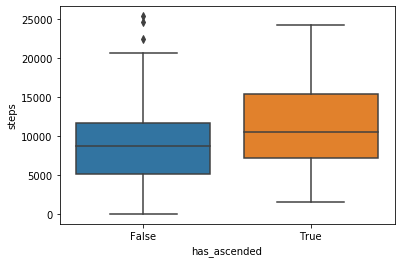

In [18]:
sns.boxplot(x='has_ascended', y='steps', data=df)

In [19]:
df.groupby('has_ascended').steps.describe()

,count,mean,std,min,25%,50%,75%,max
has_ascended,,,,,,,,
False,314.0,8811.127389,4632.416710,0.0,5109.25,8734.5,11703.5,25356.0
True,275.0,11264.810909,5172.970992,1481.0,7172.50,10480.0,15444.5,24234.0


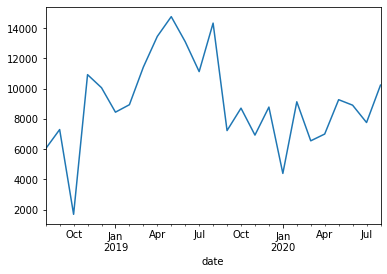

In [20]:
df[df.has_ascended == False].steps.resample('M').mean().plot.line()

### Am I more likely to hit my goal on days I ascend stairs?

In [21]:
#create new feature called hit_goal for walked more than 10,000 steps
df['hit_goal'] = df.steps >= 10_000

In [22]:
untrue = round(df.groupby('has_ascended').hit_goal.mean()[0]*100, 1)
unfalse = round(df.groupby('has_ascended').hit_goal.mean()[1]*100, 1)

In [23]:
print(f'On days I ascend a flight of stairs I hit my steps goal {unfalse}% of the time,')
print(f'On days where I do not ascend a flight of stairs I hit my steps goal {untrue}% of the time')


On days I ascend a flight of stairs I hit my steps goal 60.4% of the time,
On days where I do not ascend a flight of stairs I hit my steps goal 43.6% of the time


### What days of the week do I hit my goal?

In [24]:
df['day_of_the_week'] = df.index.strftime('%w-%a')

In [25]:
df.steps.mean()

9956.735144312393

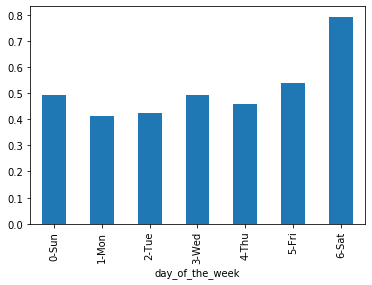

In [26]:
df.groupby('day_of_the_week').hit_goal.mean().plot.bar()


In [27]:
# How much do I walk?
df.steps.describe()

count      589.000000
mean      9956.735144
std       5039.222937
min          0.000000
25%       6018.000000
50%      10053.000000
75%      13052.000000
max      25356.000000
Name: steps, dtype: float64

Text(0.5, 1.0, 'Histogram of distribution of steps')

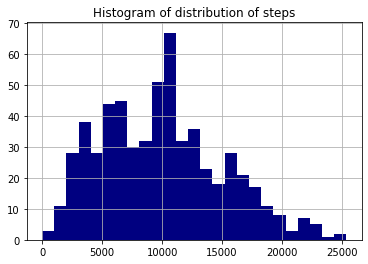

In [28]:
df.steps.hist(bins=25, color='navy')
plt.title('Histogram of distribution of steps')

**Takeaways**: There is a spike right around 10,000 steps which is my daily goal. 

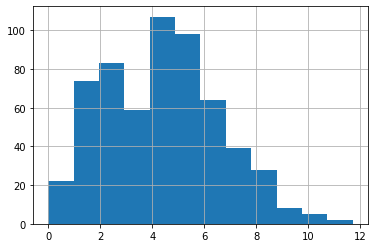

In [29]:
df.distance.hist(bins=12)

### What day of the week do I walk the most steps

In [30]:
df['weekday'] = df.index.day_name()

In [31]:
df['day_of_the_week'] = df.index.strftime('%w') + "-" + df.weekday

Text(0.5, 1.0, 'Average Steps by Month')

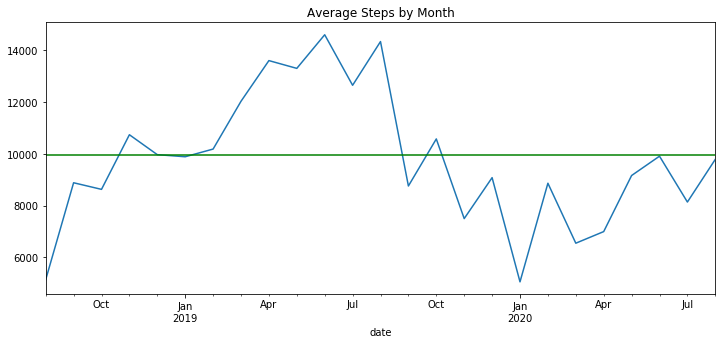

In [32]:
plt.figure(figsize=(12,5))
df.steps.resample("M").mean().plot()
plt.axhline(y=df.steps.mean(), color='g', linestyle='-')
plt.title("Average Steps by Month")

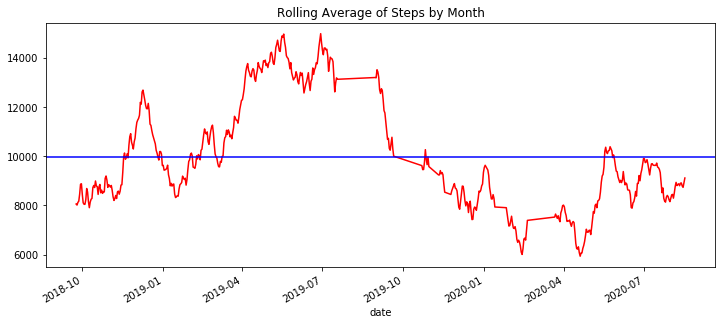

In [33]:
plt.figure(figsize=(12,5))
df.steps.rolling(30).mean().plot(color="Red")
plt.title("Rolling Average of Steps by Month")
plt.axhline(y=df.steps.mean(), color='b', linestyle='-')

### What day of the week do I walk the most?

In [34]:
df.groupby('weekday').steps.describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
Friday,82.0,10545.609756,5257.514156,2184.0,6066.5,10346.0,14757.50,22464.0
Monday,85.0,8182.870588,4262.544877,482.0,4683.0,8159.0,10712.00,19111.0
Saturday,82.0,13461.829268,4995.104798,2128.0,10171.5,12963.0,16964.25,25356.0
Sunday,87.0,9573.045977,4299.389835,1277.0,6480.0,9630.0,11893.50,24639.0
Thursday,83.0,9358.710843,5084.233020,839.0,5075.5,8852.0,12954.50,22507.0
Tuesday,85.0,8834.364706,4950.241620,1479.0,5081.0,8597.0,11872.00,24234.0
Wednesday,85.0,9880.164706,4786.116009,0.0,5965.0,9998.0,13407.00,21305.0


Text(0, 0.5, 'Steps')

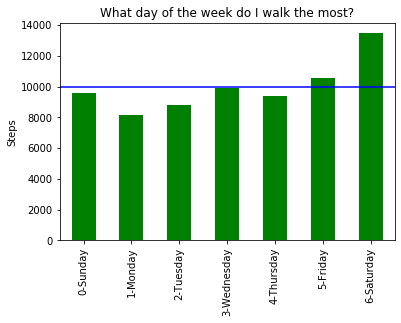

In [35]:
df.groupby('day_of_the_week').steps.mean().plot.bar(color="green")
plt.title("What day of the week do I walk the most?")
plt.xlabel("")
plt.axhline(y=df.steps.mean(), color='b', linestyle='-')
plt.ylabel("Steps")

Text(0.5, 1.0, 'Examining steps by day using Boxplot')

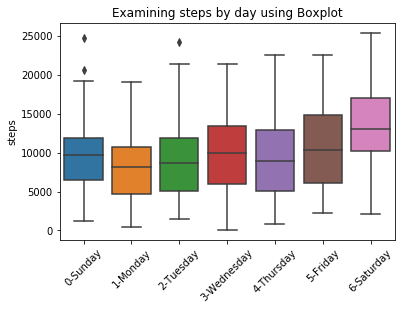

In [36]:
sns.boxplot(x='day_of_the_week', y='steps', data=df)
plt.xticks(rotation=45)
plt.xlabel("")
plt.title('Examining steps by day using Boxplot')

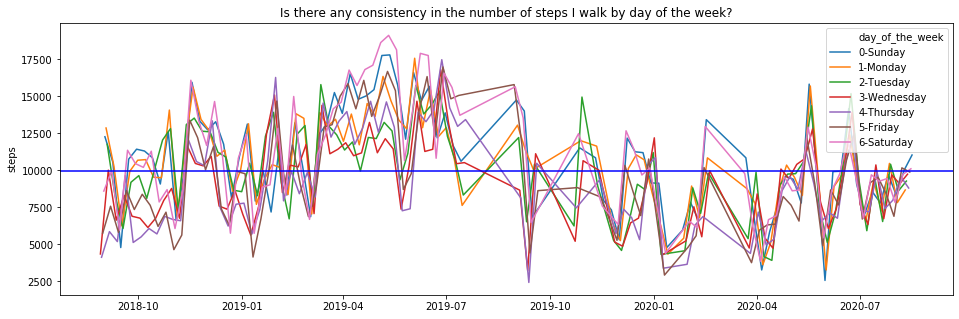

In [37]:
plt.figure(figsize=(16,5))
sns.lineplot(x=df.index, y=df.steps.rolling(4).mean(), data=df, hue='day_of_the_week')
plt.title("Is there any consistency in the number of steps I walk by day of the week?")
plt.xlabel("")
plt.axhline(y=df.steps.mean(), color='b', linestyle='-')

### Examining Steps per Mile

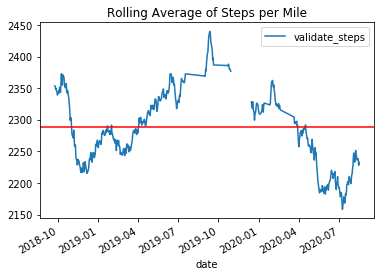

In [38]:
df.validate_steps.rolling(30).mean().plot()
plt.title('Rolling Average of Steps per Mile')
plt.axhline(y=df.validate_steps.mean(), color='r', linestyle='-')
plt.legend()

## Is there an observation bias, that causes me to conciously pass 10,000 steps for a day?
- Should my steps per day be normally distributed?
- Is there a statistical significance to what is being observed?

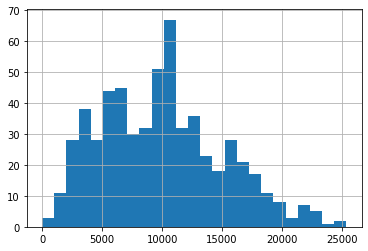

In [39]:
df.steps.hist(bins=25)

# Exploring FB prophet

In [40]:
import pandas as pd
from fbprophet import Prophet

In [41]:
dff = df[['steps']].reset_index()
dff.rename(columns={'steps':'y',
                   'date': 'ds'}, inplace=True)


In [42]:
m = Prophet()

In [43]:
m.fit(dff)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
future = m.make_future_dataframe(periods=365)

In [45]:
forecast = m.predict(future)

In [46]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
949,2021-08-12,3747.206977,-1907.028172,9643.758295
950,2021-08-13,4926.678595,-1190.092798,11006.942826
951,2021-08-14,7854.073761,2030.865971,13588.231081
952,2021-08-15,3971.459152,-1580.178363,9849.009011
953,2021-08-16,2548.291097,-3048.609114,8645.012145


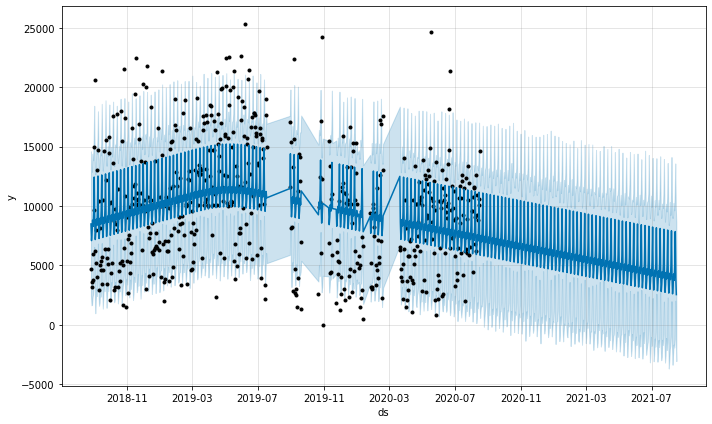

In [47]:
fig1 = m.plot(forecast)

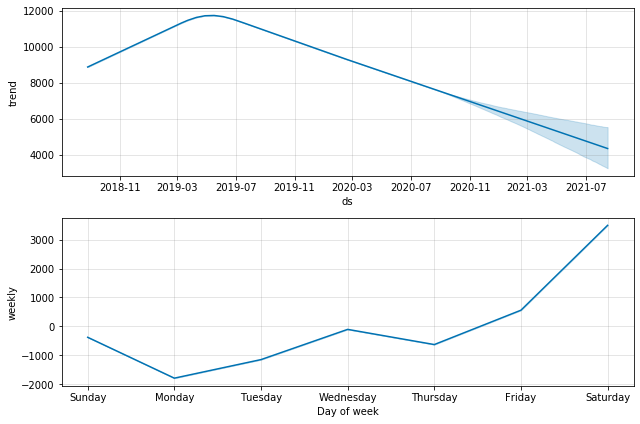

In [48]:
fig2 = m.plot_components(forecast)


In [ ]:
import fbprophet
print(fbprophet.__version__)
import pandas
print(pandas.__version__)